### Complex text recognition using DFT

In [1]:
import numpy as np

import cv2
import os
from math import ceil
from matplotlib import pyplot as plt
from copy import deepcopy
# The library for checking texts simmilarity by number of changes needed to make to convert from one text to another
from Levenshtein import distance as levenshtein_distance

In [2]:
SCRIPT_PATH = os.getcwd()
TEXTS_DIRECTORY = os.path.join(SCRIPT_PATH, "texts")
CHARACTERS_DIRECTORY = os.path.join(SCRIPT_PATH, "fonts/alphabets")
ALPHABETS_DIRECTORY = os.path.join(SCRIPT_PATH, "alpha")

GREEN = (0, 255, 0)
BLACK = (0, 0, 0)
MARGIN = 20


Function to add custom margin to any image that can be displayed as numpy array

In [3]:
def add_margins(image, margin) :
    h, w = image.shape[:2]
    new_image = np.full((h + 2 * margin, w + 2 * margin, 3), 255, dtype=np.uint8)
    new_image[margin:margin+h, margin:margin+w] = image
    return new_image

Function for plotting images

In [4]:
def plot_image(image, titl = "", colormap = "gray") :
    plt.figure(figsize=(10, 10))
    plt.plot()
    plt.imshow(image, cmap = colormap)
    plt.title(titl)
    plt.axis('off')
    plt.show()

Calculating texts simmilarity using Levenshtein distance

In [5]:
def simmilarity(a, b) :
    lev_dist = levenshtein_distance(a, b)

    max_len = max(len(a), len(b))

    return 1 - (lev_dist / max_len)

In [6]:
def invert_colors(image) :
    return cv2.bitwise_not(image)

Functions that converts image to grayscale and vice versa

In [7]:
def to_grayscale(image):
    if len(image.shape) == 2:
        return image  # Image is already in grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.bitwise_not(grayscale)

def from_grayscale(image) :
    
    image_array = np.asarray(cv2.bitwise_not(image))
    return np.array([[(val, val, val) for val in row] for row in image_array])

Function that reads png file for every letter and symbol in used alphabet and saves it to dictionary with symbol as key

In [8]:
def initialize_characters(font_name) :
    alphabet_directory = os.path.join(CHARACTERS_DIRECTORY, font_name + "_alphabet")
    filenames = os.listdir(alphabet_directory)
    filenames.sort(key = lambda x : ord(x.split(".")[0]))
    characters = {}
    for name in filenames :
        text = name.split(".")[0]
        char = text
        if text == "A" : text = "."
        elif text == "B" : text = ","
        elif text == "C" : text = "?"
        elif text == "D" : text = "!"
        elif text == "E" : text = "("
        elif text == "F" : text = ")"
        elif text == "Z" : text = " "
        characters[text] = to_grayscale(cv2.imread(os.path.join(alphabet_directory, char + ".png")))
        
    return characters
        

Function that finds filename for image file, file with correct text displayed on image, and finds font used to write the text

In [9]:
def find_data(filenumber) :
    
    filename = None
    check_name = None
    font_name = None

    filenumber_str = str(filenumber)

    for file in os.listdir(TEXTS_DIRECTORY) :
        filetable = file.split("_")
        if filetable[0] == filenumber_str :
            font_name = filetable[2]
            if filetable[1] == "image" :
                filename = file
                if check_name is not None : break
            elif filetable[1] == "text" :
                check_name = file
                if filename is not None : break
    
    
    with open(os.path.join(TEXTS_DIRECTORY, check_name), 'r') as f:
        text_content = f.read()
                
    return filename, text_content, font_name


Functions for displaying every letter in alphabet (from the letter picture dictionary)

In [10]:
def new_line(col_num, i) :
    val = i % col_num
    if val == 0 : return i
    row_num = (i - val) // col_num
    i = (row_num + 1) * col_num
    return i

def plot_images(characters, items_in_row=10) :
    fig = plt.figure(figsize=(10, 7))
    rows_num, columns_num = ceil((len(characters) - 10 - 26) / items_in_row) + ceil(10/items_in_row) + ceil(26/items_in_row), items_in_row
    i = 0
    for character_key in characters :
        if character_key == "a" or character_key == "." : 
            i = new_line(columns_num, i)
        fig.add_subplot(rows_num, columns_num, i + 1)
        plt.imshow(invert_colors(add_margins(from_grayscale(characters[character_key]), 1)), cmap="gray")
        plt.axis("off")
        i += 1
    plt.show()

Function that calculates the number of black pixels (black eventhough the value is equal to 255 which represents white, because original letters are black, and we are working on the color inverted versions of those images) for later sorting of characters

In [11]:
def black_pixels(image) :
    w, h = image.shape
    output = 0
    for x in range(w) :
        for y in range(h) :
            if image[x, y] == 255 : output += 1
    return output

Function that sorts every character by it's field to ensure that biggest characters are matched before smaller ones - which solves the problem of matching single dot everywhere, eventhough every letter is displayed with margins to be the size of the line

In [12]:
def sort_characters(characters) :
    ordered_characters = list(characters)
    ordered_characters.sort(key = lambda x : black_pixels(characters[x]), reverse = True)
    return ordered_characters

Function to rotate image by given angle - used to straighten tilted image

In [13]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    cos = np.abs(np.cos(angle))
    sin = np.abs(np.sin(angle))
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    M = cv2.getRotationMatrix2D(center, angle * 180 / np.pi, 1.0)
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    rotated = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

This function ensures that only black and white pixels exist - this makes pattern matching easier

In [14]:
def blacked(image_array):
    mask = np.any(image_array != [255, 255, 255], axis=-1)
    image_array[mask] = [0, 0, 0]
    return image_array

Function to remove any margin from image

In [15]:
def cut_image(image) :
    image_array = np.array(image)

    non_white_cols = np.any(np.any(image_array != [255, 255, 255], axis=-1), axis=1)
    non_white_rows = np.any(np.any(image_array != [255, 255, 255], axis=-1), axis=0)

    minimal_row = float('inf')
    maximal_row = float('-inf')
    minimal_col = float('inf')
    maximal_col = float('-inf')

    for i in range(len(non_white_rows)) :
        val = non_white_rows[i]
        if val :
            minimal_row = min(minimal_row, i)
            maximal_row = max(maximal_row, i + 1)
    for i in range(len(non_white_cols)) :
        val = non_white_cols[i]
        if val :
            minimal_col = min(minimal_col, i)
            maximal_col = max(maximal_col, i + 1)
    
    x_range = maximal_row - minimal_row
    y_range = maximal_col - minimal_col
    
    new_image_array = np.zeros((y_range, x_range, 3))
    
    for x in range(x_range) :
        for y in range(y_range) :
            new_image_array[y,x] = image_array[minimal_col + y, minimal_row + x]
    
    return blacked(new_image_array)

Functions to denoise and straighten image - used to make tilted images whatsoever managable by the program


In [16]:
def denoise_image(image) :
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)


def straighten_image(image) :
    global MARGIN
    image = from_grayscale(image)
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    angles = []
    if lines is not None :
        for _, theta in lines[:, 0] :
            angles.append(theta - np.pi / 2)
    
    if angles :
        mean_angle = np.mean(angles)
    else:
        mean_angle = 0
    
    new_image = cut_image(rotate_image(image, mean_angle))
    
    straightened_image = denoise_image(add_margins(new_image, MARGIN))
    
    return to_grayscale(straightened_image)


Function to check if the given point is local maximum - same as in exercise 1

In [17]:
def is_maximum(table, x, y, previously_found):
    h, w = table.shape
    val = table[x, y]
    stack = [(x, y)]
    local_max = (x, y)
    
    while stack:
        cx, cy = stack.pop()
        if (cx, cy) in previously_found:
            continue
        previously_found.add((cx, cy))
        neighbors = [
            (i, j) for i in range(max(0, cx - 1), min(cx + 2, h))
                   for j in range(max(0, cy - 1), min(cy + 2, w))
                   if (i, j) not in previously_found
        ]
        for i, j in neighbors:
            if table[i, j] > val:
                return False, None
            if table[i, j] == val:
                stack.append((i, j))
                if (j, i) > (local_max[1], local_max[0]):
                    local_max = (i, j)
                    
    return True, local_max

Function that checks for best matching points for every letter - it uses is_maximum function to get rid of the same letter appearing in the same place multiple times - local maximums are often more than one point, so all of them could be accepted as valid letter appearance, instead, only one point for each maximum is accepted. Function also ereases found letter from image to avoid future incorrect matches. It also don't save the letter appearance in alphabet, which will be explained later

In [18]:
def check_pattern(correlation, probability, mark, base_height, image):
    p_h, p_w = mark
    max_points = np.argwhere(correlation > probability)
    
    sorted_indices = np.argsort(correlation[max_points[:, 0], max_points[:, 1]])[::-1]
    max_points = max_points[sorted_indices]
    
    new_points = set()
    
    for x, y in max_points:
        if (x, y) in new_points:
            continue
        boolean, point = is_maximum(correlation, x, y, set())
        if boolean:
            new_points.add(point)
    
    max_points = list(new_points)
    max_points.sort(key=lambda pt: correlation[pt], reverse=True)
    
    appearances = []
    
    for x, y in max_points:
        point = (y - p_w, x - p_h)
        if x <= base_height:
            appearances.append(point)
        image[max(0, point[1]):x + 1, max(0, point[0]):y + 1] = 0
    
    return appearances, image

Same as in assignment 1 function to find correlation between specific image and pattern

In [19]:
def find_corelation(image, pattern) :
    h, w = image.shape
    correlation = np.fft.ifft2(np.fft.fft2(image) * np.fft.fft2(np.rot90(np.rot90(pattern)), s = (h, w))).real
    correlation /= np.abs(np.max(correlation))
    return correlation

This function allows us to use clever trick of adding alphabet to every image, which allows us to efficiently normalise correlation matrixes, because every character is always at least once in text - thanks to that we can take high probability of appearance for every letter, and letters can just not be found in image. Alphabet is placed at bottom of image, so appearances of the letters in alphabet can be later avoided in actual text

In [20]:
def add_alphabet(image, font_name):
    font_name = font_name.replace("_", "")
    
    filename = os.path.join(ALPHABETS_DIRECTORY, f"image_{font_name}_.png")
    alphabet_image = to_grayscale(cv2.imread(filename))
    
    i_h, i_w = image.shape
    a_h, a_w = alphabet_image.shape
    
    new_h, new_w = i_h + a_h, max(i_w, a_w)
    new_image = np.full((new_h, new_w), 0, dtype=np.uint8)
    
    image_start = (0, (new_w - i_w) // 2)
    alphabet_start = (i_h, (new_w - a_w) // 2)
    
    new_image[image_start[0]:image_start[0] + i_h, image_start[1]:image_start[1] + i_w] = image
    new_image[alphabet_start[0]:alphabet_start[0] + a_h, alphabet_start[1]:alphabet_start[1] + a_w] = alphabet_image
    
    return new_image

Function that is the sole heart of program. It calculates pattern appearances for every single letter and saves it to dictionary for further use in deciphering points to letters placed in text order

In [21]:
def find_letters(image, font_characters, font_name, probability, addition = True, plot_addition = False) :
    ordered_characters = sort_characters(font_characters)
    ordered_characters.pop()
    
    height = image.shape[0]
    if addition :
        image = add_alphabet(image, font_name)
        if plot_addition :
            plot_image(image,"image with alphabet added")
    
    character_data = {}
    
    for character in ordered_characters :
        pattern = font_characters[str(character)]
        correlation = find_corelation(image, pattern)
        mark = pattern.shape
        character_data[character], image = check_pattern(correlation, probability, mark, height, image)
    
    return character_data

Function that assigns letter to every point, so it can later be printed in text

In [22]:
def create_points_of_intrest(character_data) :
    points_of_intrest = {}
    for key, values in character_data.items() :
        for point in values :
            points_of_intrest[point] = key
    return points_of_intrest

In [23]:
def distance(point_a, point_b) :
    return np.sqrt(((point_a[0] - point_b[0])**2) + ((point_a[1] - point_b[1])**2))

Function that assumes the starting point of text, it just takes leftmost of the highest points and assumes it's starting point for text. It is mostly right to some extent as even after straightening (which isn't perfect) the images are mostly only little tilted, so assuming that point is good enough

In [24]:
def find_first_point(points, line_height) :
    upmost_point = min(points, key = lambda x : (x[1], x[0]))
    
    def find(point) :
        nonlocal upmost_point, line_height
        if point[1] < upmost_point[1] + line_height :
            return point[0]
        return float('inf')

    leftmost_point = min(points, key = lambda x : find(x))
            
    return leftmost_point

Functions that orders points by it's position to match text structure. Points at simmilar heights are grouped together in lines and then sorted by their x value, to they are positioned as text in lines from left to right (which means that this program supports only languages written from up to bottom and from left to right, but it can be changed quite simply)

In [25]:
def order_points(input_points, line_height) :
    points = deepcopy(input_points)
    
    lines = []
    while points :
        first_point = find_first_point(points, line_height)
        line = [first_point]
        for point in points :
            if point == first_point : continue
            if np.abs(point[1] - first_point[1]) < line_height :
                line.append(point)
        line.sort(key = lambda x : x[0])
        for point in line :
            points.remove(point)
        lines.append(line)
    
    return lines

Function that understands point to point relation to decipher text. It assigns letters to specific locations, so it can create the final version of text with spaces and even blank lines

In [26]:
def understand_points(character_data, font_characters, space_multiplicator) :
    space_height, space_width = font_characters[" "].shape
    space_width = int(round(space_width*(space_multiplicator)))
    
    
    points_of_intrest = create_points_of_intrest(character_data)
    points = list(points_of_intrest)
    lines = order_points(points, space_height)
    text = ""
    if (len(lines) < 1) : return text
    line_height = lines[1][0][1] - lines[0][0][1]
    
    for i, line in enumerate(lines) :
        prev = line[0]
        x = prev[0]
        y = prev[1]
        letter = points_of_intrest[prev]
        text += letter
        end_x = font_characters[letter].shape[1] + x
        for point in line :
            if point == prev : continue
            x = point[0]
            space_count = (x - end_x) // space_width
            for _ in range(space_count) :
                text += " "
            letter = points_of_intrest[point]
            text += letter
            end_x = font_characters[letter].shape[1] + x
            prev = point
        if i != len(lines) - 1 :
            next_y = lines[i + 1][0][1]
            for _ in range(round(((next_y - y) / line_height))) :
                text += "\n"
            
        else : break
    
    return text

The main function of program. It just combines every other function from program in right order of operations so it can distinguish text from .png file. It also serves as summary of work of on every important stage of work, such as loading image, inverting colors, straightening image and recognizing text. At the end the function compares the created text to actual text on the screen to report back the accuracy of program's work

In [27]:
def read(filenumber, addition = True) :
    filename, check, font_name = find_data(filenumber)
    
    image = to_grayscale(cv2.imread(os.path.join(TEXTS_DIRECTORY, filename)))
    plot_image(invert_colors(image), "Original image " + str(filenumber) + ", font " + font_name)
    font_characters = initialize_characters(font_name)
    print(font_name, "font characters")
    plot_images(font_characters)
    
    plot_image(image, "Inverted image " + str(filenumber))
    
    probability = 0.97
    
    if filenumber < 2 :
        image = straighten_image(image)
        probability = 0.81
        if font_name == "Arial" : probability = 0.88
        plot_image(image, "Straightened image " + str(filenumber))
    
    space_multiplicator = 1.55
    if font_name == "Arial" : space_multiplicator = 0.7
    
    character_data = find_letters(image, font_characters, font_name, probability, addition, plot_addition=True)
    
    for character in character_data :
        print(character, ":", len(character_data[character]), "of", check.count(character), "appearances", end = "; ")
    print("\n=====")
    
    text = understand_points(character_data, font_characters, space_multiplicator)
    
    print(text)
    print("=====")
    print(check)
    print("=====")
    
    print(round(simmilarity(text, check)*100,2),"%")

In [29]:
def find_best(filenumber, initial_probability = 0.97, initial_space_miltiplicator = 10, accuracy = 0.001) :
    filename, check, font_name = find_data(filenumber)
    
    image = to_grayscale(cv2.imread(os.path.join(TEXTS_DIRECTORY, filename)))
    font_characters = initialize_characters(font_name)
    
    probability = 1
    # spacing = 1.55
    # if font_name == "Arial" : spacing = 0.7
    spacing = 2
    jump = 0.01
    
    prev_result = 0
    result = read2(deepcopy(image), deepcopy(font_characters), deepcopy(font_name), deepcopy(check), deepcopy(probability), deepcopy(spacing))
    
    while np.abs(result - prev_result) >= accuracy or result < accuracy :
        print(result*100)
        probability -= jump
        prev_result = result
        result = read2(deepcopy(image), deepcopy(font_characters), deepcopy(font_name), deepcopy(check), deepcopy(probability), deepcopy(spacing))
        if result > prev_result :
            jump /= -2
        print(probability)
    print()
    return result

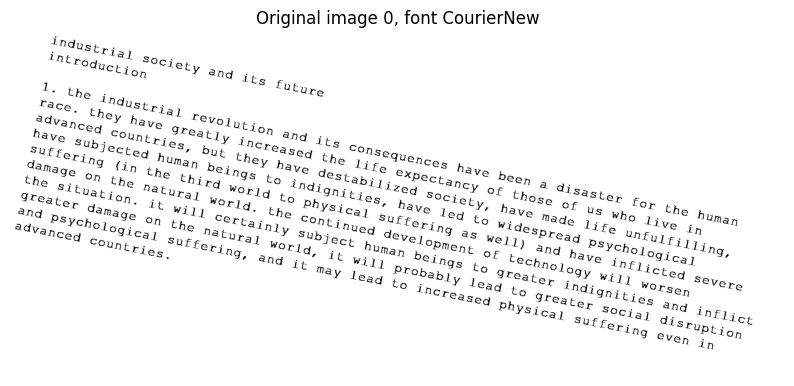

CourierNew font characters


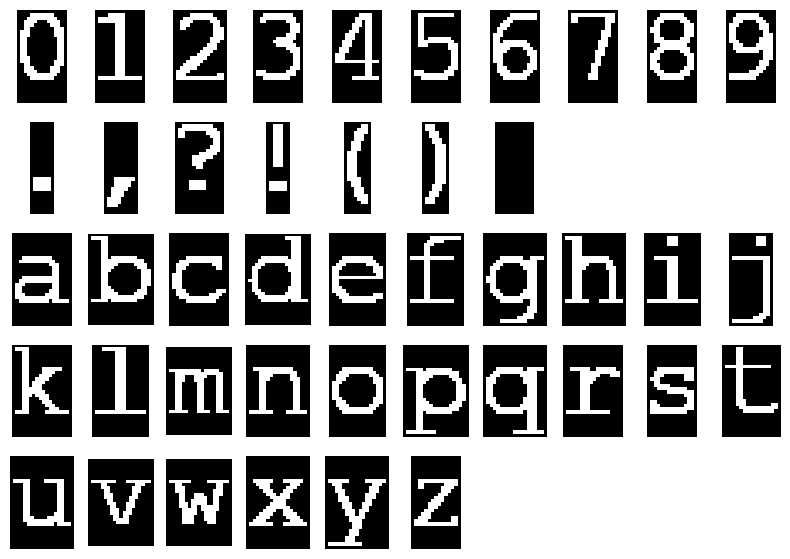

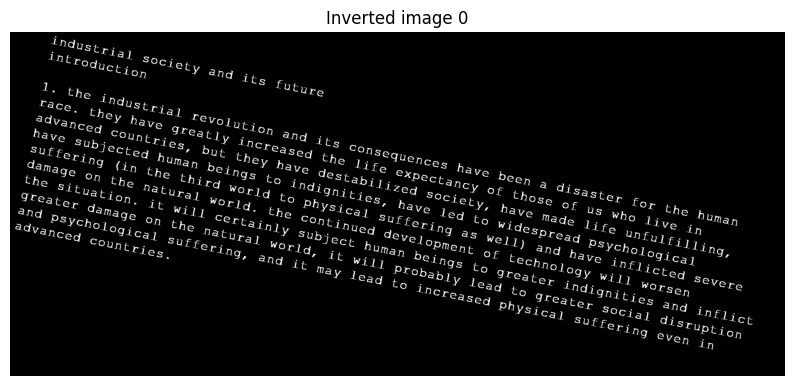

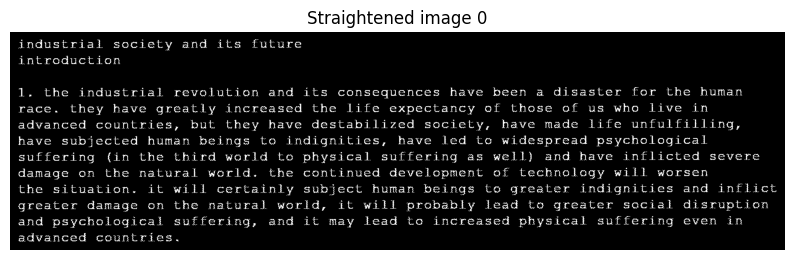

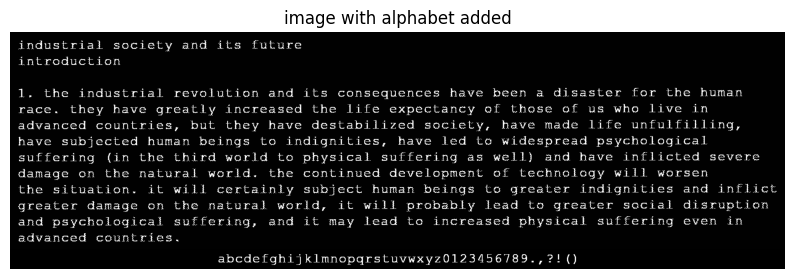

q : 2 of 1 appearances; 8 : 0 of 0 appearances; d : 37 of 37 appearances; g : 17 of 18 appearances; p : 9 of 9 appearances; b : 8 of 9 appearances; 9 : 0 of 0 appearances; 6 : 0 of 0 appearances; w : 10 of 10 appearances; 0 : 0 of 0 appearances; h : 28 of 28 appearances; m : 8 of 8 appearances; 2 : 0 of 0 appearances; x : 1 of 1 appearances; y : 14 of 14 appearances; k : 0 of 0 appearances; a : 52 of 55 appearances; 3 : 0 of 0 appearances; e : 74 of 84 appearances; s : 36 of 38 appearances; 4 : 0 of 0 appearances; o : 40 of 39 appearances; 5 : 0 of 0 appearances; c : 24 of 28 appearances; n : 51 of 54 appearances; u : 27 of 27 appearances; 1 : 17 of 1 appearances; v : 14 of 14 appearances; r : 34 of 35 appearances; ? : 0 of 0 appearances; l : 60 of 40 appearances; z : 1 of 1 appearances; ( : 1 of 1 appearances; f : 12 of 19 appearances; ) : 1 of 1 appearances; t : 51 of 56 appearances; j : 2 of 2 appearances; i : 27 of 63 appearances; 7 : 0 of 0 appearances; ! : 0 of 0 appearances; , :

In [36]:
read(0)

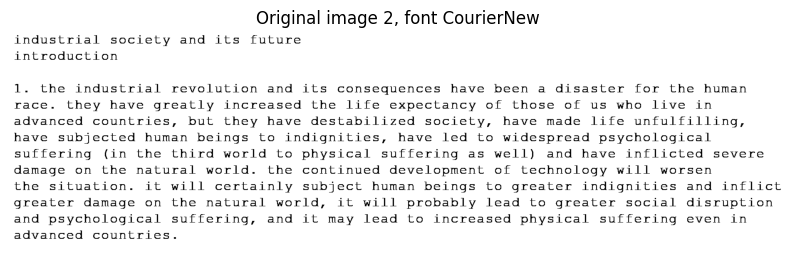

CourierNew font characters


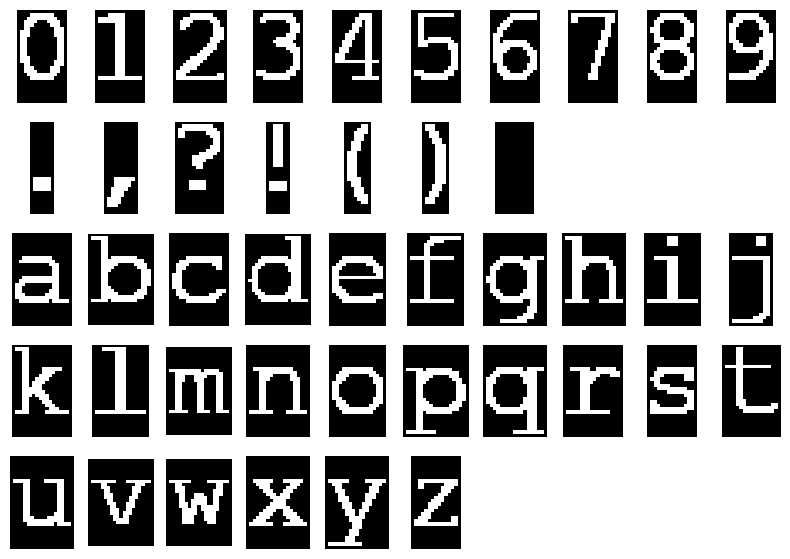

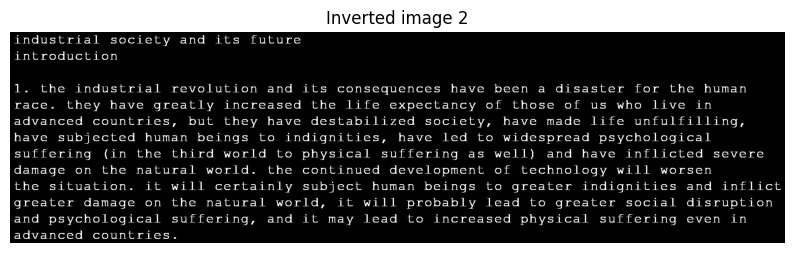

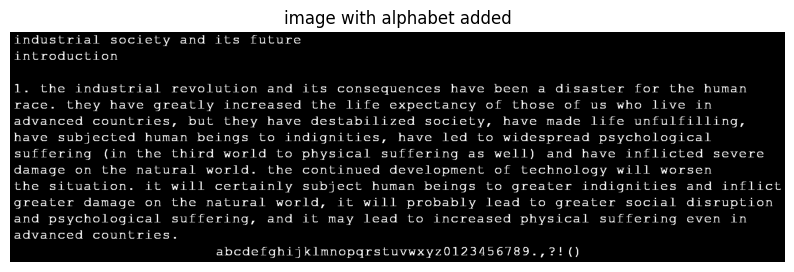

q : 1 of 1 appearances; 8 : 0 of 0 appearances; d : 37 of 37 appearances; g : 18 of 18 appearances; p : 9 of 9 appearances; b : 9 of 9 appearances; 9 : 0 of 0 appearances; 6 : 0 of 0 appearances; w : 10 of 10 appearances; 0 : 0 of 0 appearances; h : 28 of 28 appearances; m : 8 of 8 appearances; 2 : 0 of 0 appearances; x : 1 of 1 appearances; y : 14 of 14 appearances; k : 0 of 0 appearances; a : 55 of 55 appearances; 3 : 0 of 0 appearances; e : 84 of 84 appearances; s : 38 of 38 appearances; 4 : 0 of 0 appearances; o : 39 of 39 appearances; 5 : 0 of 0 appearances; c : 28 of 28 appearances; n : 54 of 54 appearances; u : 27 of 27 appearances; 1 : 1 of 1 appearances; v : 14 of 14 appearances; r : 35 of 35 appearances; ? : 0 of 0 appearances; l : 40 of 40 appearances; z : 1 of 1 appearances; ( : 1 of 1 appearances; f : 19 of 19 appearances; ) : 1 of 1 appearances; t : 56 of 56 appearances; j : 2 of 2 appearances; i : 63 of 63 appearances; 7 : 0 of 0 appearances; ! : 0 of 0 appearances; , : 

In [31]:
read(2)

In [32]:
# read(1)

In [33]:
# read(2)

In [34]:
# read(3)

# Analysis

Accuracy of algorith is surprisingly high, yet it has some hardcoded probability values and multiplicators designed for specific fonts and the fact if the image is rotated or not. It can be changed, so the program looks for right values itself. Given every circumstances. I believe results are far beyond what I expected, and percentage higher that 80 is success itself

# Bonus image without alphabet addition

In [35]:
# read(0,False)

Well, the result speaks for itself. Program assumes that every single sign is in the photo, so it has to match it, if we want to anyhow normalize correlation matrix. Adding alphabet is really powerful trick, that helps with correct normalization of correlation matrix, which means better result for every photo. It also doesn't matter, because we can always cut the photo to match our needs, or do the entirety of operations on the copy of photo, however, we only care about text, so image becomes irrelevant